In [1]:
# Proyecto 2:  Filtros sobre Imágenes (CNN)
# Clasificacion de imagenes con Filtros y redes neuronales convolucionales (CNN)
# Balam Kaled Moreno Amaro

import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

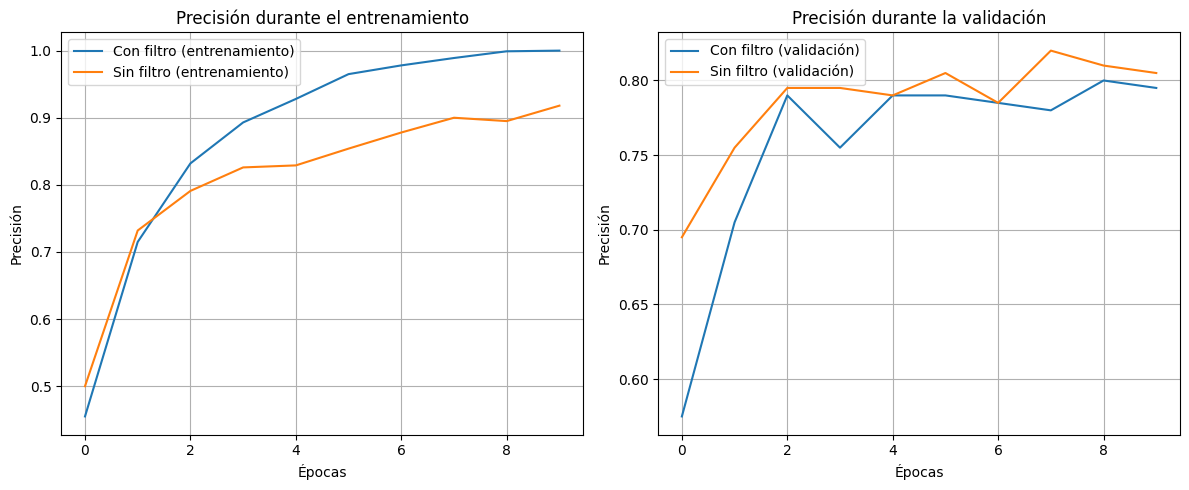


 Precisión durante la prueba CON filtro Sobel: 0.82
Precisión durante la prueba SIN filtro Sobel: 0.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


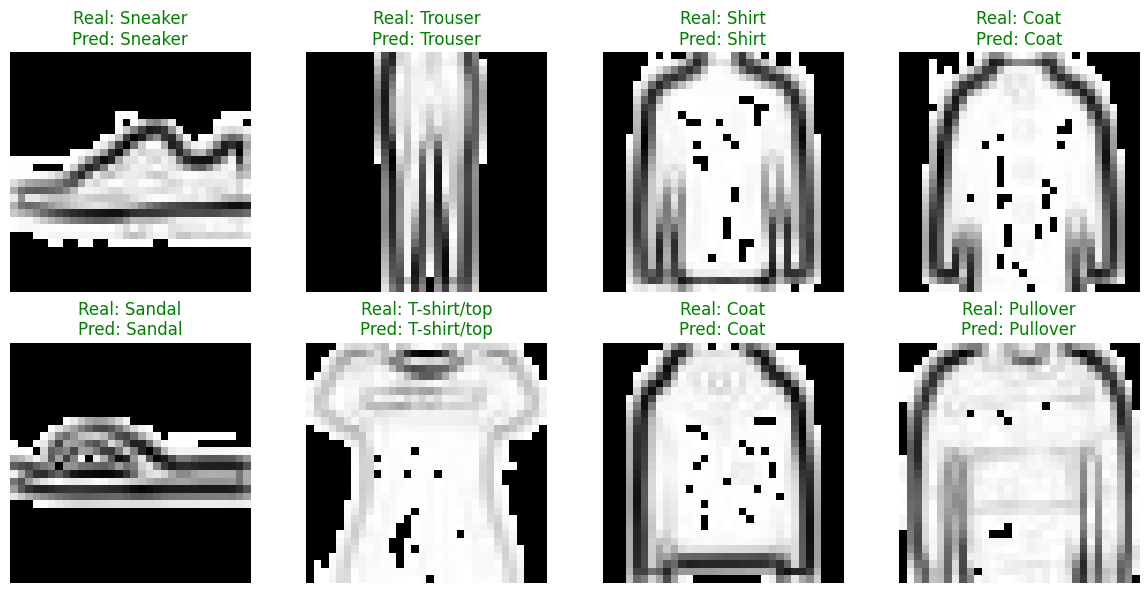

In [7]:
# Se cargan y preprocesan los datos del repositorio de Fashion-MNIST, dicho repositorio consiste en imagenes en escala de grises de prendas de vestir
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Convertimos de escala de grises a RGB al replicar tres veces las imagenes. Asimismo redimensionamos a 32x32 (para ambos modelos)
x_train = np.repeat(x_train[..., np.newaxis], 3, axis=-1)
x_test = np.repeat(x_test[..., np.newaxis], 3, axis=-1)
x_train = np.array([cv2.resize(img, (32, 32)) for img in x_train])
x_test = np.array([cv2.resize(img, (32, 32)) for img in x_test])

# Normalizar y preparar etiquetas
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

# Aplicamos el  filtro Sobel (solo al subconjunto de entrenamiento y prueba)
def sobel_filter(images):
    img_fil = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        sobel = np.sqrt(sobel_x**2 + sobel_y**2)
        sobel = cv2.normalize(sobel, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img_fil.append(cv2.cvtColor(sobel, cv2.COLOR_GRAY2RGB))
    return np.array(img_fil)

# Extraemos las primeras 1000 imágenes para entrenamiento y 200 para prueba (ambos modelos)
x_train_subset = x_train[:1000]
y_train_subset = y_train[:1000]
x_test_subset = x_test[:200]
y_test_subset = y_test[:200]

# Creamos versiones filtradas
x_train_filtered = sobel_filter(x_train_subset)
x_test_filtered = sobel_filter(x_test_subset)

# Creamos una función para construir el modelo (misma arquitectura para ambos casos para una comparacion justa)
def build_model():
    modelo = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    modelo.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return modelo

# Entrenamos el modelo CON filtro Sobel
modelo_con_filtro = build_model()
history_with_filter = modelo_con_filtro.fit(
    x_train_filtered, y_train_subset,
    epochs=10,
    validation_data=(x_test_filtered, y_test_subset),
    verbose=0  # Ocultar salida para claridad
)

# Entrenar modelo SIN filtro Sobel
modelo_sin_filtro = build_model()
history_without_filter = modelo_sin_filtro.fit(
    x_train_subset, y_train_subset,
    epochs=10,
    validation_data=(x_test_subset, y_test_subset),
    verbose=0
)

# Comparamos las precisiones en entrenamiento y validación
plt.figure(figsize=(12, 5))

# Gráfica de la precisión durante el entrenamiento
plt.subplot(1, 2, 1)
plt.plot(history_with_filter.history['accuracy'], label='Con filtro (entrenamiento)')
plt.plot(history_without_filter.history['accuracy'], label='Sin filtro (entrenamiento)')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()

# Gráfica de precisión durante la validación
plt.subplot(1, 2, 2)
plt.plot(history_with_filter.history['val_accuracy'], label='Con filtro (validación)')
plt.plot(history_without_filter.history['val_accuracy'], label='Sin filtro (validación)')
plt.title('Precisión durante la validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Evaluamos ambos modelos en el conjunto de prueba
test_acc_with_filter = model_with_filter.evaluate(x_test_filtered, y_test_subset, verbose=0)[1]
test_acc_without_filter = model_without_filter.evaluate(x_test_subset, y_test_subset, verbose=0)[1]

print(f'\n Precisión durante la prueba CON filtro Sobel: {test_acc_with_filter:.2f}')
print(f'Precisión durante la prueba SIN filtro Sobel: {test_acc_without_filter:.2f}')

# Mostramos las predicciones del conjunto con el filtro Sobel
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Seleccionamos 8 imágenes aleatorias del conjunto de prueba filtrado
np.random.seed(42)
sample_indices = np.random.choice(len(x_test_filtered), 8)
sample_images = x_test_filtered[sample_indices]
sample_labels = np.argmax(y_test_subset[sample_indices], axis=1)

# Realizamos las predicciones
predictions = model_with_filter.predict(sample_images)
predicted_labels = np.argmax(predictions, axis=1)

# Mostramos imágenes con las etiquetas reales y predichas
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    
    img_to_show = (sample_images[i] * 255).astype(np.uint8)  
    
    plt.imshow(img_to_show)
    
    color = 'green' if predicted_labels[i] == sample_labels[i] else 'red'
    plt.title(f'Real: {class_names[sample_labels[i]]}\nPred: {class_names[predicted_labels[i]]}', color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()